In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.protocols.simple_moves import *
init()
import math
import random
import numpy as np

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-1600102372 seed_offset=0 real_seed=-1600102372
core.init.random: RandomGenerat

In [2]:
def find_minimum(pose, sf):
    
    minimum = Pose()
    total_residue = pose.total_residue()

    # Random starting config
    for i in range(1, total_residue+1):
        
        pose.set_phi(i, random.uniform(-180.0,180.0))
        pose.set_psi(i, random.uniform(-180.0,180.0))
    
    move_map = MoveMap()
    move_map.set_bb(True)
   
    # Find local minimum
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.score_function(sf)
    min_mover.movemap(move_map)
    min_mover.min_type('dfpmin_armijo_nonmonotone')
    min_mover.apply(pose)
    
    pose.set_phi(1, pose.phi(1)-360.0*round(pose.phi(1)/360.0))
    pose.set_psi(1, pose.psi(1)-360.0*round(pose.psi(1)/360.0))

    minimum.assign(pose)
    print minimum.phi(1), minimum.psi(1)
    return minimum

In [3]:
def mine_minimum(pose, sf, phi_min, psi_min, E_cutoff):

    def testMin(E_curr, E_min):
        if E_curr < E_min-0.05:
            return True
        else:
            return False
    
    phi_list = []
    psi_list = []
    total_residue = pose.total_residue()
    tor_range = 0.5
    E_min = sf(pose)
    E_ceil = E_min + E_cutoff
    E_curr = E_ceil
    E_old = E_min
    phi_new = phi_min
    psi_new = psi_min
    
    for i in range(1, total_residue+1):
        
        new = Pose()
        new.assign(pose)
        
        while E_curr <= E_ceil and phi_new > -180:
            
            new.set_phi(i, new.phi(i)-tor_range)
            E_curr = sf(new)
            if testMin(E_curr, E_old):
                break
                
            E_old = E_curr
            phi_new = new.phi(1)
        
        
        phi_list.append(phi_new)
        new.assign(pose)
        phi_new = phi_min
        E_curr = E_ceil
        E_old = E_min
        
        while E_curr <= E_ceil and phi_new < 180:
            
            new.set_phi(i, new.phi(i)+tor_range)
            E_curr = sf(new)
            if testMin(E_curr, E_old):
                break
            E_old = E_curr
            phi_new = new.phi(1)
        
        phi_list.append(phi_new)
        new.assign(pose)
        phi_new = phi_min
        E_curr = E_ceil
        E_old = E_min
        
        while E_curr <= E_ceil and psi_new > -180:
            
            new.set_psi(i, new.psi(i) - tor_range)
            E_curr = sf(new)
            if testMin(E_curr, E_old):
                break
            E_old = E_curr
            psi_new = new.psi(1)

        psi_list.append(psi_new)
        new.assign(pose)
        psi_new = psi_min
        E_curr = E_ceil
        E_old = E_min
        
        while E_curr <= E_ceil and psi_new < 180:
            
            new.set_psi(i, new.psi(i) + tor_range)
            E_curr = sf(new)
            if testMin(E_curr, E_old):
                break
            E_old = E_curr
            psi_new = new.psi(1)
              
        psi_list.append(psi_new)
        new.assign(pose)
        psi_new = psi_min
        E_curr = E_ceil
        E_old = E_min

    return phi_list, psi_list

In [4]:
def mc_integration(pose, sf, kT, phi_list, psi_list, N = 10000):
    
    total_residue = pose.total_residue()
    pose_rand = Pose()
    pose_rand.assign(pose)
    
    V = 1.0

    boltzmann = 0
    
    # Calculate configuration space volume
    for j in range(1, total_residue+1):
        
        phi_min = phi_list[2*j - 2]
        phi_max = phi_list[2*j - 1]
        psi_min = psi_list[2*j - 2]
        psi_max = psi_list[2*j - 1] 
        
        
        V *= ((phi_max-phi_min)*math.pi/180.0)*((psi_max-psi_min)*math.pi/180.0)
       
    # Integrate over all backbone torsions
    for i in range(0,N):
        
        for j in range(1, total_residue+1):
            
            phi_min = phi_list[2*j - 2]
            phi_max = phi_list[2*j - 1]
            psi_min = psi_list[2*j - 2]
            psi_max = psi_list[2*j - 1]            
            pose_rand.set_phi(j, random.uniform(phi_min, phi_max))
            pose_rand.set_psi(j, random.uniform(psi_min, psi_max))

            boltzmann += math.exp(-sf(pose_rand)/kT)
            
    boltzmann = boltzmann/N
    return -kT*math.log(boltzmann*V), V

In [5]:
def check_overlap(trial_phis, trial_psis, phi_list, psi_list):
    
    trial_phi_min = trial_phis[0]
    trial_phi_max = trial_phis[1]
    trial_psi_min = trial_psis[0]
    trial_psi_max = trial_psis[1]
        
    phi_min = phi_list[0]
    phi_max = phi_list[1]
    psi_min = psi_list[0]
    psi_max = psi_list[1]
    
    if trial_phi_min > phi_max or phi_min > trial_phi_max:
        return False
        
    if trial_psi_max < psi_min or psi_max < trial_psi_min:
        return False
 
    return True
    

In [6]:
def check_minimum(pose, phi_lists, psi_lists):
    
    phi_min = pose.phi(1)
    psi_min = pose.psi(1)
    
    for i in range(0, len(phi_lists)):
        
        phi_list = phi_lists[i]
        psi_list = psi_lists[i]
        
        if phi_min > phi_list[0] and phi_min < phi_list[1] and psi_min > psi_list[0] and psi_min < psi_list[1]:
            
            return True
        
    return False
    

In [7]:
energies = []

for i in range(0,1):
    

    # Simulate alanine dipeptide
    scorefxn = get_fa_scorefxn()
    pose_original = pose_from_file('alanine-dipeptide-implicit.pdb')

    # initialize parameters
    free_energy = 0.0 
    minima = []
    phi_lists = []
    psi_lists = []
    As = []
    E_old = 0.0
    ind = 0
    config = 0.0
    minimum = Pose()
    count = 0
    count_new = count
    kT = 1.0
    V_tot = (2*math.pi)**2
    V_sampled = 0

    # Simulate until convergence criterion is met
    while True and ind < 10000:
    
        ind += 1
    
        # Find a local minimum
        minimum.assign(find_minimum(pose_original, scorefxn))   
        minima.append(minimum)
    
        # Check that minimum isn't in well already found
        if len(minima) > 1 and check_minimum(minimum, phi_lists, psi_lists):
            minima.pop()
            continue
    
        # mine minimum for extent of well
        phi_list, psi_list = mine_minimum(minimum, scorefxn, minimum.phi(1), minimum.psi(1), 0.5)
        phi_lists.append(phi_list)
        psi_lists.append(psi_list)
    
        # Check that old minimum hasn't been found again 
        if len(minima) > 1:
        
            for i in range(0, len(minima)-1):
            
                if check_overlap(phi_list, psi_list, phi_lists[i], psi_lists[i]):
                
                
                    count_new += 1
                    minima.pop()
        
                    phi_lists.pop()
                    psi_lists.pop()
                
                    break
    
        if count_new > count:
        
            count = count_new
        
            continue
    
        # Integrate over well 
        A_j, V = mc_integration(minimum, scorefxn, 1.0, phi_list, psi_list)
    
        # Update Free Energy and volume sampled
        As.append(A_j)
        free_energy = -np.log(np.sum(np.exp(-np.array(As)/kT)))
        V_sampled += V
        print free_energy, ind, V_sampled/V_tot, phi_list, psi_list
    
        # Check convergence criterion 
        if abs(free_energy - E_old) < 0.01 or V_sampled/V_tot > 0.8:
            print free_energy
            break
        
        E_old = free_energy
    
    energies.append(free_energy)


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard res

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

(array([  5.,   8.,  27.,  24.,  16.,   7.,   9.,   2.,   1.,   1.]),
 array([-1.82706618, -1.76975011, -1.71243403, -1.65511795, -1.59780187,
        -1.5404858 , -1.48316972, -1.42585364, -1.36853756, -1.31122149,
        -1.25390541]),
 <a list of 10 Patch objects>)

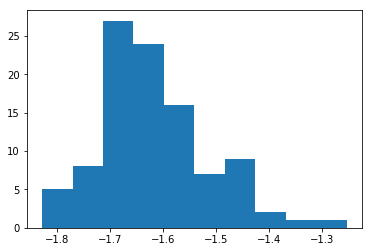

In [10]:
plt.hist(energies, 10)

In [11]:
energies = np.array(energies)

In [12]:
print np.mean(energies), np.std(energies)

-1.61778298829 0.1007974746


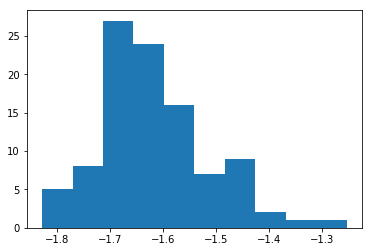

In [15]:
(n, bins, patches) = plt.hist(energies)